<a href="https://colab.research.google.com/github/nourwalid70/Speech-Emotion-Recognition/blob/main/Lab_3_speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub
!pip install --upgrade tensorflow
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.6 kB/s 
     |████████████████████████████████| 438 kB 69.5 MB/s 
     |████████████████████████████████| 1.6 MB 56.6 MB/s 
     |████████████████████████████████| 5.8 MB 50.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found ex

In [ ]:
import os
import wave
import math
import librosa, librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras import backend as K
K._get_available_gpus()

## Visualization


In [ ]:
def to_visualize(num,x):
  for s in ['SAD','ANG','DIS','FEA','HAP','NEU']:
    y, sr = librosa.load('drive/MyDrive/Colab Notebooks/Lab3/Crema/'+ num + '_' + s + '_' + x + '.wav') 
    plt.figure(figsize=(14, 5))
    plt.title('Emotion: '+ s)
    librosa.display.waveplot(y, sr=sr)

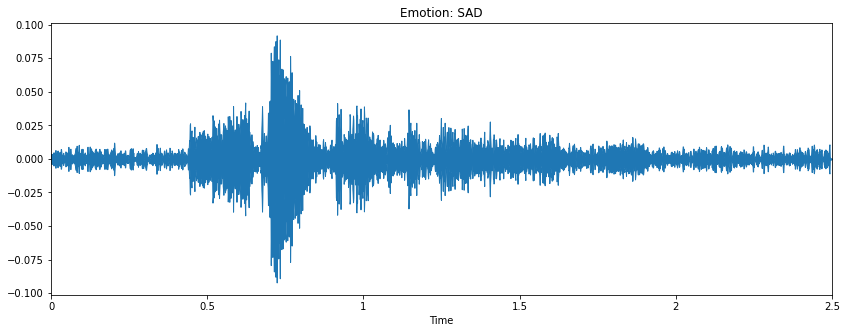

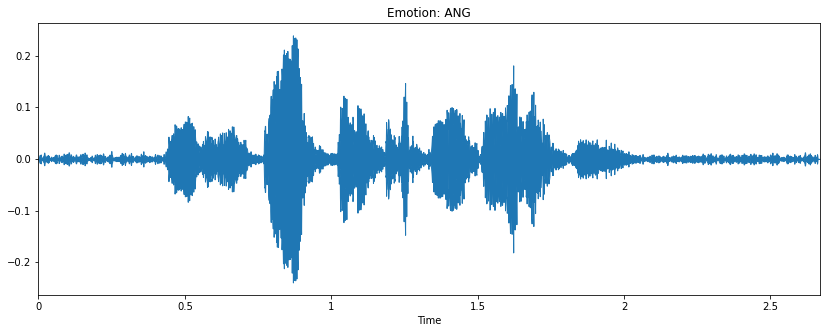

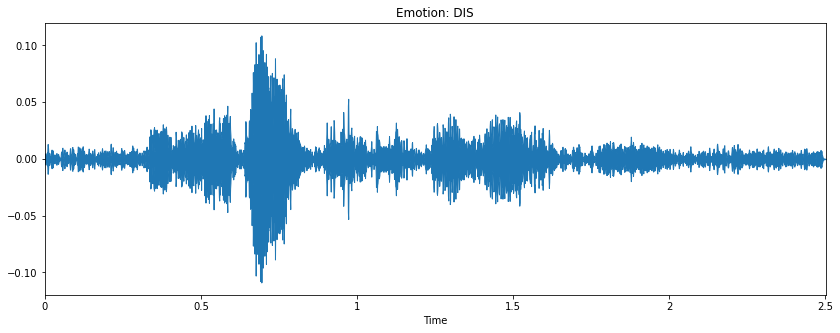

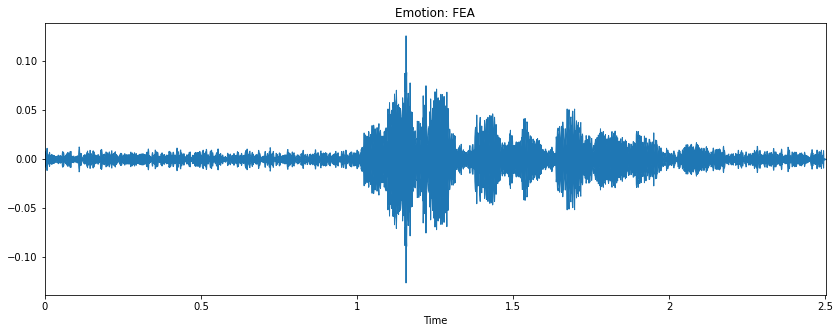

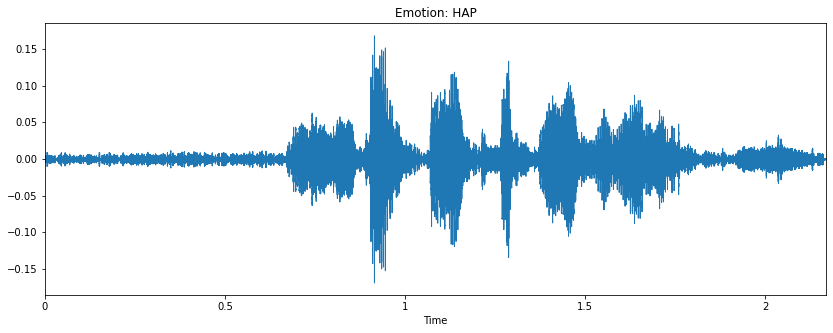

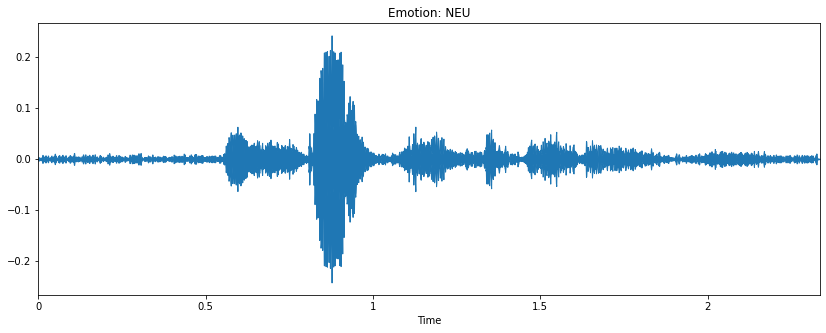

In [ ]:
audio_number = '1091_WSI'
last = 'XX'
path = 'drive/MyDrive/Colab Notebooks/Lab3/Crema/'+ audio_number + '_'
to_visualize(audio_number,last)

In [ ]:
# sad
sad_path = path + 'SAD' + '_' + last + '.wav'
y1, sr1 = librosa.load(sad_path) 
ipd.Audio(y1, rate=sr1)

In [ ]:
# angry
ang_path = path + 'ANG' + '_' + last + '.wav'
y2, sr2 = librosa.load(ang_path) 
ipd.Audio(y2, rate=sr2)

In [ ]:
# DIS
dis_path = path + 'DIS' + '_' + last + '.wav'
y3, sr3 = librosa.load(dis_path) 
ipd.Audio(y3, rate=sr3)

In [ ]:
# fear
fear_path = path + 'FEA' + '_' + last + '.wav'
y4, sr4 = librosa.load(fear_path) 
ipd.Audio(y4, rate=sr4)

In [ ]:
# happy
happy_path = path + 'HAP' + '_' + last + '.wav'
y5, sr5 = librosa.load(happy_path) 
ipd.Audio(y5, rate=sr5)

In [ ]:
# Neutral
neu_path = path + 'NEU' + '_' + last + '.wav'
y6, sr6 = librosa.load(neu_path) 
ipd.Audio(y6, rate=sr6)

# 1D model

## Augmentation

In [ ]:
def load_audio(path):
  y, sr = librosa.load(path)
  l = librosa.get_duration(y=y, sr=sr)
  y = librosa.resample(y=y,orig_sr=sr,target_sr=sr//l)
  return y, sr//l

In [ ]:
def add_noise(data, noise_factor):
  noise = np.random.randn(len(data))
  augmented_data = data + noise_factor * noise
  # Cast back to same data type
  augmented_data = augmented_data.astype(type(data[0]))
  return augmented_data

In [ ]:
def time_shift(data, sampling_rate, shift_max, shift_direction):
  shift = np.random.randint(sampling_rate * shift_max)
  if shift_direction == 'right':
      shift = -shift
  
  augmented_data = np.roll(data, shift)
  # Set to silence for heading/ tailing
  if shift > 0:
      augmented_data[:shift] = 0
  else:
      augmented_data[shift:] = 0
  return augmented_data

In [ ]:
def read_zcr_e(data):
  #ZCR
  zcrs = librosa.feature.zero_crossing_rate(data)

  #energy
  S, phase = librosa.magphase(librosa.stft(data))
  rms = librosa.feature.rms(S=S)

  return zcrs[0],rms[0]

In [ ]:
p = 'drive/MyDrive/Colab Notebooks/Lab3/Crema/1001_DFA_ANG_XX.wav'
y, sr = load_audio(p)
z,e = read_zcr_e(y)

y_noise = add_noise(y, 0.01)
z_noise, e_noise = read_zcr_e(y_noise)

y_sh_r = time_shift(y, sr, 0.3, 'left')
z_sh_r, e_sh_r = read_zcr_e(y_sh_r)

y_sh_l = time_shift(y, sr, 0.3, 'right')
z_sh_l, e_sh_l = read_zcr_e(y_sh_l)

len(z), len(e), len(z_noise), len(e_noise), len(z_sh_r), len(e_sh_r), len(z_sh_l), len(e_sh_l)



(44, 44, 44, 44, 44, 44, 44, 44)

In [ ]:
def read_melspec(path):
  # mel spectrogram
  y, sr = librosa.load(path)
  melspec = librosa.feature.melspectrogram(y,sr)
  return melspec.mean()

## Generate dataframe

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/Lab3/Crema/'
files = os.listdir(path)
labels = []
str_label = {"SAD":0,"ANG":1,"DIS":2,"FEA":3,"HAP":4,"NEU":5}
cols = range(88) # 44 + 44
audio_df = pd.DataFrame(columns = cols)

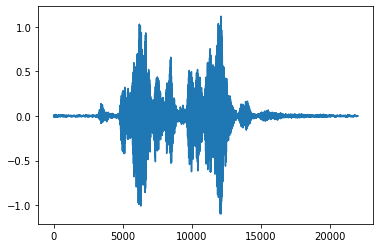

In [ ]:
# read original audios
i = 0
#loop on files
for filename in files: 
  i+=1
  if i%100==0:
    print(i)
  audio = path + filename 
  y, sr = load_audio(audio) 
  zcr, e = read_zcr_e(y)
  label = str_label[filename.split("_")[2]]
  labels.append(label)
  audio_df.loc[len(audio_df)] = np.concatenate((zcr,e),axis=None)
audio_df["label"] = labels

In [ ]:
# read audios with noise
i = 0
#loop on files
for filename in files: 
  i+=1
  if i%100==0:
    print(i)
  audio = path + filename  
  y, sr = load_audio(audio) 
  y_noise = add_noise(y, 0.01)
  zcr, e = read_zcr_e(y_noise)
  label = str_label[filename.split("_")[2]]
  labels.append(label)
  audio_df.loc[len(audio_df)] = np.concatenate((zcr,e),axis=None)
audio_df["label"] = labels

In [ ]:
# read audios with right shift
i = 0
#loop on files
for filename in files: 
  i+=1
  if i%100==0:
    print(i)
  audio = path + filename  
  y, sr = load_audio(audio) 
  y_sh_r = time_shift(y, sr, 0.3, 'right')
  zcr, e = read_zcr_e(y_sh_r)
  label = str_label[filename.split("_")[2]]
  labels.append(label)
  audio_df.loc[len(audio_df)] = np.concatenate((zcr,e),axis=None)
audio_df["label"] = labels

In [ ]:
# read audios with left shift
i = 0
#loop on files
for filename in files: 
  i+=1
  if i%100==0:
    print(i)
  audio = path + filename  
  y, sr = load_audio(audio) 
  y_sh_l = time_shift(y, sr, 0.3, 'left')
  zcr, e = read_zcr_e(y_sh_l)
  label = str_label[filename.split("_")[2]]
  labels.append(label)
  audio_df.loc[len(audio_df)] = np.concatenate((zcr,e),axis=None)
audio_df["label"] = labels

In [ ]:
audio_df.to_csv('drive/MyDrive/Colab Notebooks/Lab3/shift_l.csv')

## Reload data

In [ ]:
# original dataset
audio_df_original = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/data_Z_e.csv', index_col = 0)
# with noise
audio_df_noise = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/noise.csv', index_col = 0)
# shift left
audio_df_sh_l = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/shift_l.csv', index_col = 0)
# shift right
audio_df_sh_r = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/shift_right.csv', index_col = 0)

In [ ]:
# original
audio_df = audio_df_original

In [ ]:
# original + noise
audio_df = pd.concat([audio_df_original, audio_df_noise])

In [ ]:
# original + shift left
audio_df = pd.concat([audio_df_original, audio_df_sh_l])

In [ ]:
# original + shift right
audio_df = pd.concat([audio_df_original, audio_df_sh_r])

In [ ]:
# original + noise + shift left
audio_df = pd.concat([audio_df_original, audio_df_noise, audio_df_sh_l])

In [ ]:
# original + noise + shift left + shift right
audio_df = pd.concat([audio_df_original, audio_df_noise, audio_df_sh_l, audio_df_sh_r])

In [ ]:
audio_df

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,label
0,0.028809,0.039062,0.051758,0.049316,0.052246,0.062988,0.076660,0.118652,0.154785,0.167969,...,0.004511,0.003936,0.003617,0.004074,0.003377,0.002897,0.002900,0.002971,0.002382,4
1,0.031738,0.047363,0.062988,0.058105,0.063965,0.089355,0.129395,0.162109,0.174805,0.160645,...,0.003932,0.003854,0.003515,0.003202,0.002989,0.002490,0.002589,0.002973,0.002402,1
2,0.025879,0.043945,0.057617,0.055176,0.052734,0.046387,0.047852,0.047852,0.053711,0.060059,...,0.002918,0.003623,0.003779,0.002835,0.002794,0.002960,0.003071,0.003411,0.003041,5
3,0.022949,0.036621,0.046875,0.048828,0.051758,0.067383,0.078613,0.089844,0.155762,0.160645,...,0.004474,0.003182,0.002340,0.002671,0.002847,0.002426,0.002405,0.002973,0.003078,1
4,0.029785,0.059082,0.120605,0.200684,0.288574,0.330078,0.291504,0.241211,0.163574,0.125000,...,0.003442,0.003233,0.002804,0.002910,0.002805,0.003075,0.003318,0.004088,0.003894,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,0.041992,0.062500,0.082031,0.082520,0.078125,0.079102,0.080566,0.093750,0.117188,0.121582,...,0.003523,0.002708,0.002727,0.003861,0.004315,0.003739,0.002205,0.000368,0.000000,5
7438,0.027832,0.046387,0.063965,0.070801,0.074219,0.071777,0.084961,0.091309,0.095703,0.104492,...,0.005123,0.005624,0.005303,0.004032,0.002965,0.003012,0.004265,0.003383,0.001160,4
7439,0.032715,0.048828,0.068848,0.071777,0.068848,0.072754,0.070312,0.069336,0.072266,0.073242,...,0.003453,0.003538,0.003806,0.003216,0.003375,0.003960,0.003729,0.001851,0.000261,3
7440,0.039062,0.056152,0.075684,0.076660,0.074707,0.079102,0.083008,0.079102,0.083008,0.081055,...,0.003080,0.003170,0.003290,0.002874,0.002793,0.001805,0.000281,0.000000,0.000000,2


## Splitting data

In [ ]:
# 70% training , 30% testing
train_set, test_set = train_test_split(audio_df, test_size=0.3, stratify=audio_df['label'])
X_train, Y_train = train_set.iloc[:,:-1], train_set['label']
X_test, Y_test = test_set.iloc[:,:-1], test_set['label']
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

## Training and tuning

In [ ]:
def create_model1(input_size):
  #defining model
  model_1D = Sequential()
  #adding convolution layer
  model_1D.add(Conv1D(32,kernel_size=5,padding='same',activation='relu',input_shape=input_size))
  model_1D.add(Conv1D(64,kernel_size=5,padding='same',activation='relu')) 
  model_1D.add(Conv1D(32,kernel_size=5,padding='same',activation='relu')) 
  #adding pooling layer
  model_1D.add(MaxPool1D(2))
 
  #Add dropout
  model_1D.add(Dropout(0.5))
  #adding fully connected layer
  model_1D.add(Flatten())
  model_1D.add(Dense(1000,activation='relu'))
  #adding output layer
  model_1D.add(Dense(6,activation='softmax'))
  #compiling the model
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model_1D.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=[SparseCategoricalAccuracy()])
  return model_1D

In [ ]:
def create_model2(input_size):
  #defining model
  model_1D = Sequential()
  #adding convolution layer
  model_1D.add(Conv1D(128,kernel_size=5,padding='same',activation='relu',input_shape=input_size))
  model_1D.add(Conv1D(64,kernel_size=5,padding='same',activation='relu')) 
  model_1D.add(Conv1D(32,kernel_size=5,padding='same',activation='relu')) 
  #adding pooling layer
  model_1D.add(MaxPool1D(2))
 
  #Add dropout
  model_1D.add(Dropout(0.5))
  #adding fully connected layer
  model_1D.add(Flatten())
  model_1D.add(Dense(100,activation='relu'))
  #adding output layer
  model_1D.add(Dense(6,activation='softmax'))
  #compiling the model
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model_1D.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=[SparseCategoricalAccuracy()])
  return model_1D

In [ ]:
def create_model3(input_size):

  model_1D = Sequential()

  #define regulizers
  reg = regularizers.L1(1e-7)

  #convolution layers
  model_1D.add(Conv1D(32,kernel_size=5,padding='same',activation='relu', kernel_initializer='random_normal', kernel_regularizer= reg ,input_shape=input_size))
  model_1D.add(Dropout(0.1))
  model_1D.add(Conv1D(64,kernel_size=5,padding='same',activation='relu', kernel_initializer='random_normal', kernel_regularizer= reg)) 
  model_1D.add(Dropout(0.1))
  model_1D.add(Conv1D(32,kernel_size=5,padding='same',activation='relu', kernel_initializer='random_normal', kernel_regularizer= reg)) 
  model_1D.add(Dropout(0.1))
  model_1D.add(MaxPool1D(1)) 


  #fully connected layers
  model_1D.add(Flatten())
  model_1D.add(Dense(100,activation='relu', kernel_regularizer= reg))
  model_1D.add(Dropout(0.1))
  model_1D.add(Dense(100,activation='relu', kernel_regularizer= reg))
  model_1D.add(Dropout(0.1))
  
  #output layer
  model_1D.add(Dense(6,activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model_1D.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=[SparseCategoricalAccuracy()])
  return model_1D

In [ ]:
n_split = 20
batch_size = 16
avg_val_acc = 0
avg_train_acc = 0
callback = EarlyStopping(monitor='loss', patience=3)
for train_index,test_index in KFold(n_split).split(X_train):
  val_X_train,val_X_test=X_train[train_index],X_train[test_index]
  val_Y_train=Y_train[train_index]
  val_Y_test = Y_train[test_index]

  #print('debug : ', len(val_X_train), len(val_Y_train), len(val_X_test), len(val_Y_test))
    
  model = create_model3((88,1)) # 44 * 4
  #fitting the model
  model.fit(val_X_train, val_Y_train,epochs=100, verbose=0, batch_size = batch_size,callbacks=[callback])
  n, t = model.evaluate(val_X_train, val_Y_train, batch_size = batch_size)
  l, m = model.evaluate(val_X_test,val_Y_test, batch_size = batch_size)
  avg_val_acc += m
  avg_train_acc += t
print('training accuracy : ',avg_train_acc/n_split, ', validation accuracy : ', avg_val_acc/n_split)

66/66 [==============================] - 0s 3ms/step - loss: 1.3079 - sparse_categorical_accuracy: 0.4870
training accuracy :  0.6464538097381591 , validation accuracy :  0.48802522867918013


## Big Picture

In [ ]:
def big_picture(model, x_test, y_test):

  #displaying testing accuracy
  h, a = model.evaluate(x_test, y_test)
  print('testing accuracy:', a)

  y_prob = model.predict(x_test) 
  y_pred = y_prob.argmax(axis=-1)
  # y_pred = model.predict_classes(x_test)

  #printing f1-score
  f = f1_score(y_test, y_pred, average=None)
  print('f1-score:', f)

  #printing confusion matrix
  c = confusion_matrix(y_test, y_pred)
  print('confusion matrix:\n', c)

  #plotting confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix = c, display_labels=["SAD","ANG","DIS","FEA","HAP","NEU"])
  disp.plot()
  plt.show()

In [ ]:
#reload data
# original dataset
audio_df_original = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/data_Z_e.csv', index_col = 0)
# with noise
audio_df_noise = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/noise.csv', index_col = 0)
# shift left
audio_df_sh_l = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/shift_l.csv', index_col = 0)
# shift right
audio_df_sh_r = pd.read_csv('drive/MyDrive/Colab Notebooks/Lab3/shift_right.csv', index_col = 0)

In [ ]:
#split
# 70% training , 30% testing
train_set_original, test_set_original = train_test_split(audio_df_original, test_size=0.3, stratify=audio_df_original['label'], random_state=100)

train_indices = list(train_set_original.index.values)
train_set_noise = audio_df_noise.loc[train_indices]
train_set_sh_l = audio_df_sh_l.loc[train_indices]
train_set_sh_r = audio_df_sh_r.loc[train_indices]

#final train and test sets
train_set = pd.concat([train_set_original, train_set_noise, train_set_sh_l, train_set_sh_r])
test_set = test_set_original


X_train, Y_train = train_set.iloc[:,:-1], train_set['label']
X_test, Y_test = test_set.iloc[:,:-1], test_set['label']
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

Epoch 1/200
1303/1303 [==============================] - 12s 8ms/step - loss: 1.5097 - sparse_categorical_accuracy: 0.3665
Epoch 2/200
1303/1303 [==============================] - 8s 6ms/step - loss: 1.4350 - sparse_categorical_accuracy: 0.4125
Epoch 3/200
1303/1303 [==============================] - 8s 6ms/step - loss: 1.4059 - sparse_categorical_accuracy: 0.4238
Epoch 4/200
1303/1303 [==============================] - 8s 6ms/step - loss: 1.3963 - sparse_categorical_accuracy: 0.4313
Epoch 5/200
1303/1303 [==============================] - 9s 7ms/step - loss: 1.3852 - sparse_categorical_accuracy: 0.4344
Epoch 6/200
1303/1303 [==============================] - 8s 6ms/step - loss: 1.3701 - sparse_categorical_accuracy: 0.4437
Epoch 7/200
1303/1303 [==============================] - 8s 6ms/step - loss: 1.3628 - sparse_categorical_accuracy: 0.4510
Epoch 8/200
1303/1303 [==============================] - 8s 6ms/step - loss: 1.3511 - sparse_categorical_accuracy: 0.4510
Epoch 9/200
1303/1303 [

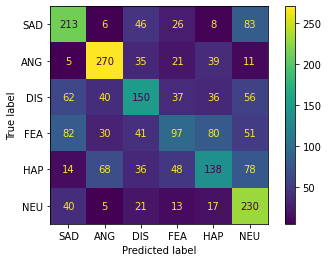

In [ ]:
batch_size = 16
model = create_model2((88, 1))
callback = EarlyStopping(monitor='loss', patience=3)
#training
model.fit(X_train, Y_train,epochs=200,callbacks=[callback], batch_size = batch_size)

big_picture(model, X_test, Y_test)

# 2D Model

# Generating Dataframe

In [ ]:
def read_melspec(path):
  # mel spectrogram
  y, sr = librosa.load(path,offset=0.5)
  l = librosa.get_duration(y=y, sr=sr)
  y = librosa.resample(y=y,orig_sr=sr,target_sr=sr//l)
  melspec = librosa.feature.melspectrogram(y,sr)
  return melspec

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/Lab3/Crema/'
files = os.listdir(path)

cols = ['melspec','label']
audio_df = pd.DataFrame(columns = cols)

#loop on files
for filename in files: 
  audio = path + filename  
  melspecmean = read_melspec(audio)
  label = filename.split("_")[2]
  audio_df.loc[len(audio_df)] = [melspecmean,label]

In [ ]:
audio_df = pd.read_pickle('drive/MyDrive/Colab Notebooks/Lab3/df_1.pkl')

In [ ]:
label = LabelEncoder() 
audio_df['label']= label.fit_transform(audio_df['label'])

# Data Splitting

In [ ]:
# 70% training , 30% testing
train_set, test_set = train_test_split(audio_df, test_size=0.3, stratify=audio_df['label'])
train_set, validation_set = train_test_split(train_set, test_size=0.05, stratify=train_set['label'])
X_train=np.stack(train_set['melspec'].values)
Y_train=np.stack(train_set['label'].values)
X_val=np.stack(validation_set['melspec'].values)
Y_val=np.stack(validation_set['label'].values)
X_test=np.stack(test_set['melspec'].values)
Y_test=np.stack(test_set['label'].values)


In [ ]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
Y_train = to_categorical(list(Y_train))

X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)
Y_val = to_categorical(list(Y_val))

X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
Y_test = to_categorical(list(Y_test))

# Model

In [ ]:
model_2D=tensorflow.keras.models.load_model('drive/MyDrive/Colab Notebooks/Lab3/model_2D_5')
model_2D=model_2D.from_config(model_2D.get_config())

In [ ]:
model_2D = Sequential()
model_2D.add(Conv2D(64,5,1,activation='relu',padding='same',kernel_regularizer=tensorflow.keras.regularizers.l2(l=0.001),input_shape=(X_train.shape[1],X_train.shape[2],1)))
model_2D.add(BatchNormalization())
model_2D.add(MaxPool2D((2,2),(2,2)))
model_2D.add(Dropout(0.4))

model_2D.add(Conv2D(128,5,1,activation='relu',padding='same',kernel_regularizer=tensorflow.keras.regularizers.l2(l=0.001)))
model_2D.add(BatchNormalization())
model_2D.add(MaxPool2D((2,2),(2,2)))
model_2D.add(Dropout(0.4))


model_2D.add(Conv2D(128,5,1,activation='relu',padding='same',kernel_regularizer=tensorflow.keras.regularizers.l2(l=0.001)))
model_2D.add(BatchNormalization())
model_2D.add(MaxPool2D((2,2),(2,2)))
model_2D.add(Dropout(0.4))

model_2D.add(Conv2D(265,5,1,activation='relu',padding='same',kernel_regularizer=tensorflow.keras.regularizers.l2(l=0.001)))
model_2D.add(BatchNormalization())
model_2D.add(MaxPool2D((2,2),(2,2)))
model_2D.add(Dropout(0.4))


model_2D.add(Conv2D(128,5,1,activation='relu',padding='same',kernel_regularizer=tensorflow.keras.regularizers.l2(l=0.001)))
model_2D.add(BatchNormalization())
model_2D.add(MaxPool2D((1,1),(2,2)))
model_2D.add(Dropout(0.4))

#adding fully connected layer
model_2D.add(Flatten())
model_2D.add(Dense(512,activation='relu'))
model_2D.add(Dense(128,activation='relu'))
model_2D.add(Dropout(0.2))

#adding output layer
model_2D.add(Dense(6,activation='softmax'))
#compiling the model
model_2D.compile(loss='categorical_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(0.0005,),metrics=['accuracy'])
#fitting the model


model_2D.fit(X_train,Y_train,batch_size=64,epochs=100,validation_data=(X_val,Y_val))

In [ ]:
def big_picture_2D(model, x_test, y_test):

  #displaying testing accuracy
  h, a = model.evaluate(x_test, y_test)
  print('testing accuracy:', a)

  y_prob = model.predict(x_test) 
  y_pred = y_prob.argmax(axis=-1)
  y_test = y_test.argmax(axis=-1)
  # y_pred = model.predict_classes(x_test)

  #printing f1-score
  f = f1_score(y_test, y_pred, average=None)
  print('f1-score:', f)

  #printing confusion matrix
  c = confusion_matrix(y_test, y_pred)
  print('confusion matrix:\n', c)

  #plotting confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix = c, display_labels=["SAD","ANG","DIS","FEA","HAP","NEU"])
  disp.plot()
  plt.show()

70/70 [==============================] - 1s 12ms/step - loss: 2.5301 - accuracy: 0.5325
testing accuracy: 0.5324675440788269
70/70 [==============================] - 1s 9ms/step
f1-score: [0.66055046 0.38888889 0.42472266 0.55969191 0.59065934 0.50454545]
confusion matrix:
 [[288  10  14  50  15   5]
 [ 78 112  18  37  39  97]
 [ 44  20 134  53  29 102]
 [ 57  12  46 218  25  23]
 [ 13  12   8  28 215  50]
 [ 10  29  29  12  79 222]]


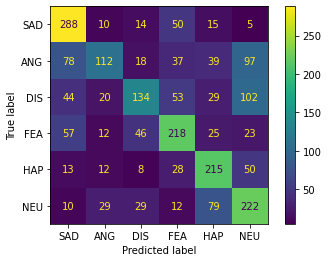

In [ ]:
big_picture_2D(model_2D, X_test, Y_test)